# Глубоко обучение. Лабораторная работа №3

**Цель:** изучить и реализовать метод переноса знаний (transfer learning) в глубоких нейронных сетях для решения задачи классификации изображений. Предлагается применение метода переноса знаний к известным моделям глубокого обучения, обученных на наборе данных ImageNet. Существуют различные подходы к переносу знаний:

- Обучение всех весов нейронной сети
- Обучение весов слоев, которые были добавлены или изменены
- Обучение нескольких последних слоев
- Обучение части слоев нейронной сети

**Требования:**

1. Необходимо выполнить следующие задачи:
    - Загрузить и проверить данные, включая демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей.
    - Загрузить 4 нейронные сети (можно использовать torchvision), обученные на наборе данных ImageNet. Требуется для каждой модели провести 2 эксперимента, используя разные конфигурация переноса знаний. Модифицировать последний слой и реализовать обучение на наборе данных Garbage Classification. Настроить гиперпараметры обучения.
    - Построить F1-score от количества эпох для всех моделей на валидационных данных. Построить сравнительную столбчатую диаграмму точностей: модель и тип эксперимента (с кратким указанием параметров) по горизонтали, F1 score на тестовых данных по вертикали.

2. Проверка корректности:
    - Разделите датасет на тренировочную, валидационную и тестовую выборки самостоятельно в соотношении 70/15/15.
    - Для оценки качества следует использовать Macro [F1-score](https://en.wikipedia.org/wiki/F-score), поскольку датасет не сбалансирован.

3. Можно использовать любые сверточные архитектуры или архитектуры на базе механизма внимания (transformer, ViT).

In [1]:
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.models as models
%matplotlib inline

In [2]:
# Гиперпараметры
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

## Подготовка данных

В качестве входных данных должен быть выбран датасет Garbage Classification с сайта https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

In [3]:
data_dir = '/work/garbage'
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### Загрузка и нормализация данных

Для создания загрузчика были использованы обучающие материалы с сайта https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, адаптированные для текущей задачи.

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
print("Dataset size:", len(dataset))

Dataset size: 2527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.2489083].


Label: metal (Class No: 2)


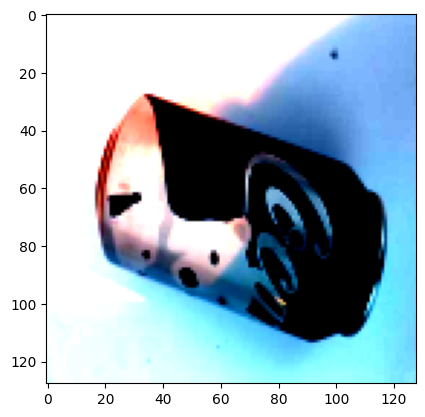

In [5]:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[999]
show_sample(img, label)

### Разделение выборки

Входные данные разделены на три независмые выборки с одинаковым распределением по классам:

* Тренировочная выборка (70%) для обучения модели
* Валидационная выборка (15%) для выбора лучшей модели
* Тестовая выборка (15%) для демонстрации результата обучения 

In [6]:
targets = dataset.targets
indices = [*range(len(dataset))]

train_indices, temp_indices = train_test_split(indices, test_size=0.3, stratify=targets)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, stratify=[targets[i] for i in temp_indices])

train_dataset = Subset(dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 1768
Validation dataset size: 379
Test dataset size: 380


## Настройка нейросетей

Для проведения экспериментов были выбраны четыре архитектуры сверточных нейросетей:

* ResNet-50 https://arxiv.org/pdf/1512.03385
* MobileNetV2 https://arxiv.org/pdf/1801.04381
* EfficientNet-B0 https://arxiv.org/pdf/1905.11946
* Densenet-121 https://arxiv.org/pdf/1608.06993

### ResNet-50

Предлагается провести два эксперимента с разными моделями на базе указанной архитектуры:

1. Обучение всех весов.
2. Добавление слоев `Dropout + Linear + ReLU` перед последним линейным слоем и обучение весов только добавленных слоев.

In [7]:
def resnet50_classic(num_classes: int):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def resnet50_modified(num_classes: int):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes),
    )
    return model

### MobileNetV2

Предлагается провести два эксперимента с разными моделями на базе указанной архитектуры:

1. Обучение всех весов.
2. Добавление блока, аналогичного блокам _Bottleneck_ в архитектуре сети, перед последним линейным слоем и обучение весов только добавленных слоев.

In [8]:
def mobilenet_v2_classic(num_classes: int):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


def mobilenet_v2_modified(num_classes: int):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    conv_block = nn.Sequential(
        nn.Conv2d(in_channels=1280, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
    )
    old_feature = model.features[-1]
    model.features[-1] = nn.Sequential(old_feature, conv_block)
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),
    )
    return model

### EfficientNet-B0

Предлагается провести два эксперимента с разными моделями на базе указанной архитектуры:

1. Обучение всех весов.
2. Добавление блока `Dropout + Linear + ReLU + BatchNorm` (для снижения риска переобучения на небольших датасетах) перед последним линейным слоем и обучение весов только добавленных слоев.

In [9]:
def efficientnet_b0_classic(num_classes: int):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


def efficientnet_b0_modified(num_classes: int):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(model.classifier[1].in_features, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes),
    )
    return model

### Densenet-121

Предлагается провести два эксперимента с разными моделями на базе указанной архитектуры:

1. Обучение всех весов.
2. Обучение всех весов, кроме весов первых двух блоков _Dense Block_ в архитектуре сети.

In [10]:
def densenet121_classic(num_classes: int):
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model


def densenet121_modified(num_classes: int):
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    for i, param in enumerate(model.parameters()):
       if i < 6 + 12:
           param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

## Обучение моделей

В качестве функции потерь будет использована кросс-энтропия (`torch.nn.CrossEntropyLoss`). Обновление параметров будет происходить с помощью метода Adam (`torch.optim.Adam`). Выбор лучшей модели будет осуществляться на основании максимального значения Macro F1 score (`sklearn.metrics.f1_score`), полученного на валидационной выборке. 

In [11]:
def model_device(model):
    return next(model.parameters()).device


@torch.no_grad()
def eval_f1(model, dataloader: DataLoader):
    device = model_device(model)
    f1_all = []
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
        f1_all.append(f1)
    return sum(f1_all) / len(f1_all)


def train_and_evaluate(model, name, train_loader, val_loader, num_epochs, learning_rate):
    device = model_device(model)
    optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0.0
    val_f1_stat = []
    for epoch in range(num_epochs):
        model.train()
        start_time = time()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        train_time = time() - start_time
        start_time = time()
        val_f1 = eval_f1(model, val_loader)
        val_time = time() - start_time
        if val_f1 > best_f1:
            torch.save(model.state_dict(), f"best_{name}.pth")
            best_f1 = val_f1
        val_f1_stat.append(val_f1)
        print(f"Epoch {epoch}: Train time {train_time:.2f} s, Validation time {val_time:.2f} s, Validation F1 {val_f1:.2f}", flush=True)
    return val_f1_stat

In [12]:
test_f1_stat = {}

assert torch.cuda.is_available(), "CUDA backend must be available"
device = torch.device("cuda")
print(device)

cuda


In [ ]:
def run_experiment(model_factory):
    global test_f1_stat
    model = model_factory(len(classes)).to(device)
    name = model_factory.__name__
    val_f1_stat = train_and_evaluate(model, name, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)
    model.load_state_dict(torch.load(f"best_{name}.pth", weights_only=True))
    test_f1 = eval_f1(model, test_loader)
    print("Test F1:", test_f1)
    plt.plot(range(NUM_EPOCHS), val_f1_stat, marker="o")
    plt.title(f"{name} validation")
    plt.xlabel("epoch")
    plt.xticks([i for i in range(NUM_EPOCHS)])
    plt.ylabel("F1 score")
    plt.grid()
    plt.show()
    test_f1_stat[name] = test_f1

Проведены эксперименты, описанные в предыдущем разделе. Значение Macro F1 score в процессе обучения представлено на соответствующих графиках.

### ResNet-50

Epoch 0: Train time 7.58 s, Validation time 1.44 s, Validation F1 0.69
Epoch 1: Train time 7.22 s, Validation time 1.46 s, Validation F1 0.82
Epoch 2: Train time 7.48 s, Validation time 1.49 s, Validation F1 0.79
Epoch 3: Train time 7.48 s, Validation time 1.50 s, Validation F1 0.78
Epoch 4: Train time 7.65 s, Validation time 1.54 s, Validation F1 0.63
Epoch 5: Train time 7.82 s, Validation time 1.65 s, Validation F1 0.80
Epoch 6: Train time 8.10 s, Validation time 1.55 s, Validation F1 0.79
Epoch 7: Train time 8.05 s, Validation time 1.60 s, Validation F1 0.75
Epoch 8: Train time 8.04 s, Validation time 1.65 s, Validation F1 0.79
Epoch 9: Train time 8.06 s, Validation time 1.58 s, Validation F1 0.77
Epoch 10: Train time 8.32 s, Validation time 1.61 s, Validation F1 0.77
Epoch 11: Train time 8.47 s, Validation time 1.67 s, Validation F1 0.82
Epoch 12: Train time 8.60 s, Validation time 1.80 s, Validation F1 0.81
Epoch 13: Train time 8.31 s, Validation time 1.67 s, Validation F1 0.80
Ep

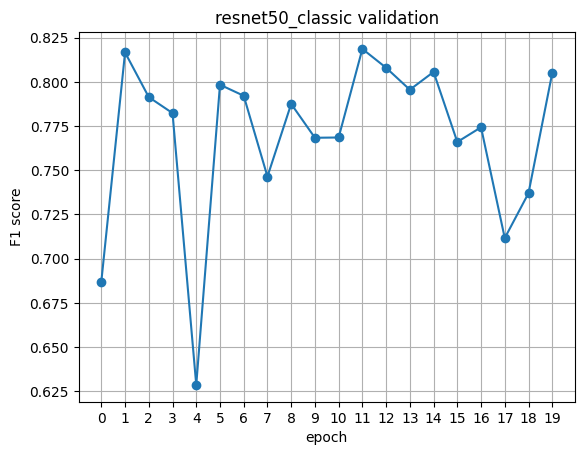

In [13]:
run_experiment(resnet50_classic)

Epoch 0: Train time 6.87 s, Validation time 1.66 s, Validation F1 0.72
Epoch 1: Train time 6.97 s, Validation time 1.69 s, Validation F1 0.75
Epoch 2: Train time 6.81 s, Validation time 1.61 s, Validation F1 0.72
Epoch 3: Train time 6.70 s, Validation time 1.69 s, Validation F1 0.75
Epoch 4: Train time 6.77 s, Validation time 1.63 s, Validation F1 0.78
Epoch 5: Train time 6.68 s, Validation time 1.66 s, Validation F1 0.77
Epoch 6: Train time 6.58 s, Validation time 1.63 s, Validation F1 0.76
Epoch 7: Train time 6.72 s, Validation time 1.65 s, Validation F1 0.78
Epoch 8: Train time 6.77 s, Validation time 1.64 s, Validation F1 0.80
Epoch 9: Train time 6.88 s, Validation time 1.62 s, Validation F1 0.81
Epoch 10: Train time 6.64 s, Validation time 1.72 s, Validation F1 0.79
Epoch 11: Train time 6.52 s, Validation time 1.60 s, Validation F1 0.80
Epoch 12: Train time 6.62 s, Validation time 1.64 s, Validation F1 0.79
Epoch 13: Train time 6.62 s, Validation time 1.65 s, Validation F1 0.81
Ep

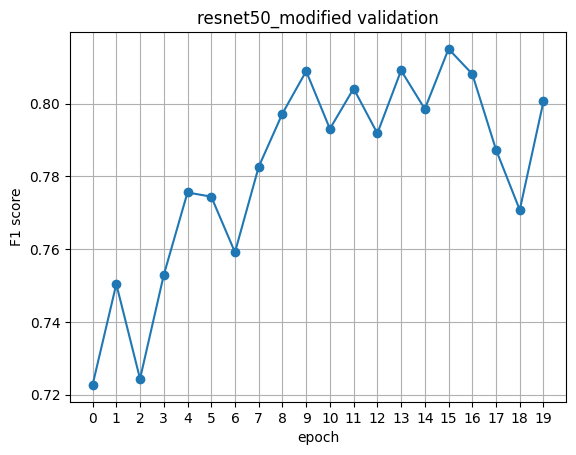

In [14]:
run_experiment(resnet50_modified)

### MobileNetV2

Epoch 0: Train time 8.40 s, Validation time 1.44 s, Validation F1 0.81
Epoch 1: Train time 8.02 s, Validation time 1.35 s, Validation F1 0.81
Epoch 2: Train time 7.99 s, Validation time 1.25 s, Validation F1 0.80
Epoch 3: Train time 7.60 s, Validation time 1.25 s, Validation F1 0.80
Epoch 4: Train time 7.72 s, Validation time 1.38 s, Validation F1 0.83
Epoch 5: Train time 7.96 s, Validation time 1.47 s, Validation F1 0.77
Epoch 6: Train time 7.88 s, Validation time 1.31 s, Validation F1 0.85
Epoch 7: Train time 8.73 s, Validation time 1.47 s, Validation F1 0.84
Epoch 8: Train time 7.60 s, Validation time 1.35 s, Validation F1 0.83
Epoch 9: Train time 8.21 s, Validation time 1.50 s, Validation F1 0.81
Epoch 10: Train time 7.57 s, Validation time 1.40 s, Validation F1 0.89
Epoch 11: Train time 7.83 s, Validation time 1.31 s, Validation F1 0.88
Epoch 12: Train time 7.35 s, Validation time 1.22 s, Validation F1 0.88
Epoch 13: Train time 7.49 s, Validation time 1.30 s, Validation F1 0.89
Ep

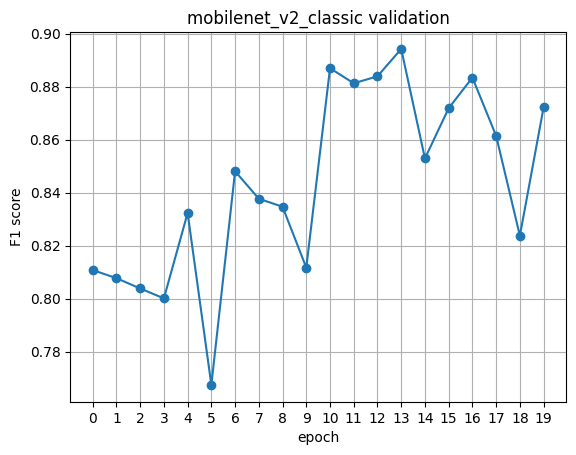

In [15]:
run_experiment(mobilenet_v2_classic)

Epoch 0: Train time 6.25 s, Validation time 1.40 s, Validation F1 0.68
Epoch 1: Train time 6.20 s, Validation time 1.43 s, Validation F1 0.73
Epoch 2: Train time 6.16 s, Validation time 1.35 s, Validation F1 0.74
Epoch 3: Train time 6.66 s, Validation time 1.55 s, Validation F1 0.76
Epoch 4: Train time 6.36 s, Validation time 1.42 s, Validation F1 0.73
Epoch 5: Train time 6.01 s, Validation time 1.35 s, Validation F1 0.78
Epoch 6: Train time 5.92 s, Validation time 1.47 s, Validation F1 0.75
Epoch 7: Train time 5.97 s, Validation time 1.30 s, Validation F1 0.76
Epoch 8: Train time 5.82 s, Validation time 1.37 s, Validation F1 0.74
Epoch 9: Train time 6.00 s, Validation time 1.37 s, Validation F1 0.73
Epoch 10: Train time 5.88 s, Validation time 1.43 s, Validation F1 0.76
Epoch 11: Train time 5.91 s, Validation time 1.36 s, Validation F1 0.77
Epoch 12: Train time 5.77 s, Validation time 1.33 s, Validation F1 0.76
Epoch 13: Train time 5.76 s, Validation time 1.39 s, Validation F1 0.74
Ep

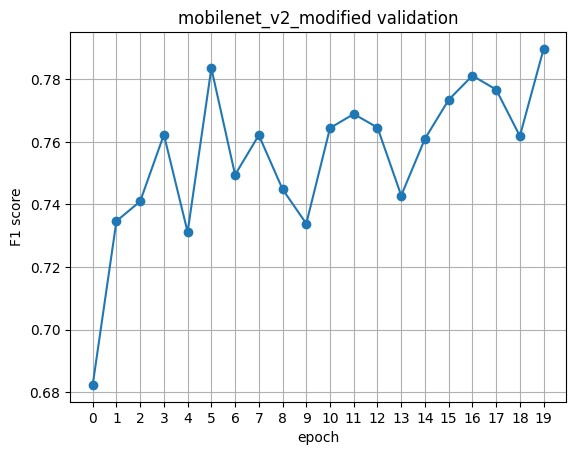

In [16]:
run_experiment(mobilenet_v2_modified)

### EfficientNet-B0

Epoch 0: Train time 8.35 s, Validation time 1.32 s, Validation F1 0.75
Epoch 1: Train time 8.42 s, Validation time 1.34 s, Validation F1 0.85
Epoch 2: Train time 8.35 s, Validation time 1.35 s, Validation F1 0.85
Epoch 3: Train time 8.70 s, Validation time 1.37 s, Validation F1 0.84
Epoch 4: Train time 8.69 s, Validation time 1.37 s, Validation F1 0.85
Epoch 5: Train time 8.48 s, Validation time 1.36 s, Validation F1 0.86
Epoch 6: Train time 8.71 s, Validation time 1.38 s, Validation F1 0.84
Epoch 7: Train time 9.05 s, Validation time 1.37 s, Validation F1 0.87
Epoch 8: Train time 9.24 s, Validation time 1.38 s, Validation F1 0.87
Epoch 9: Train time 9.17 s, Validation time 1.41 s, Validation F1 0.89
Epoch 10: Train time 9.21 s, Validation time 1.46 s, Validation F1 0.85
Epoch 11: Train time 9.87 s, Validation time 1.71 s, Validation F1 0.88
Epoch 12: Train time 10.27 s, Validation time 1.48 s, Validation F1 0.84
Epoch 13: Train time 9.04 s, Validation time 1.34 s, Validation F1 0.88
E

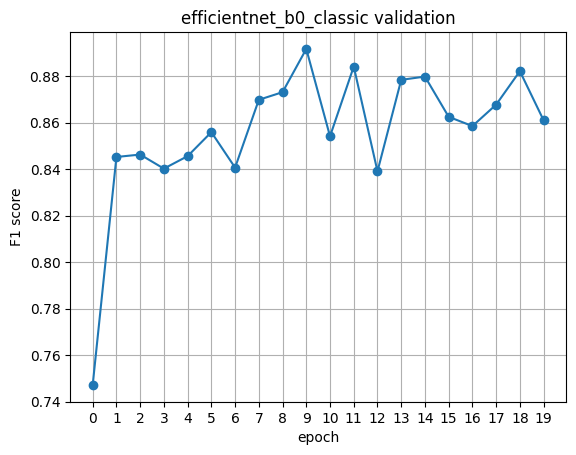

In [17]:
run_experiment(efficientnet_b0_classic)

Epoch 0: Train time 6.83 s, Validation time 1.51 s, Validation F1 0.65
Epoch 1: Train time 6.81 s, Validation time 1.47 s, Validation F1 0.68
Epoch 2: Train time 6.55 s, Validation time 1.49 s, Validation F1 0.70
Epoch 3: Train time 6.43 s, Validation time 1.44 s, Validation F1 0.70
Epoch 4: Train time 7.05 s, Validation time 1.46 s, Validation F1 0.74
Epoch 5: Train time 6.40 s, Validation time 1.46 s, Validation F1 0.71
Epoch 6: Train time 6.79 s, Validation time 1.54 s, Validation F1 0.73
Epoch 7: Train time 6.58 s, Validation time 1.49 s, Validation F1 0.70
Epoch 8: Train time 6.23 s, Validation time 1.40 s, Validation F1 0.70
Epoch 9: Train time 6.33 s, Validation time 1.42 s, Validation F1 0.73
Epoch 10: Train time 6.37 s, Validation time 1.43 s, Validation F1 0.71
Epoch 11: Train time 6.69 s, Validation time 1.88 s, Validation F1 0.76
Epoch 12: Train time 6.86 s, Validation time 1.49 s, Validation F1 0.75
Epoch 13: Train time 6.16 s, Validation time 1.46 s, Validation F1 0.73
Ep

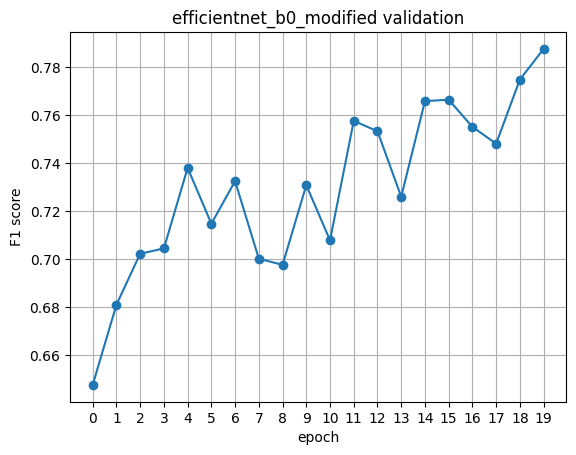

In [18]:
run_experiment(efficientnet_b0_modified)

### Densenet-121

Epoch 0: Train time 12.09 s, Validation time 1.55 s, Validation F1 0.67
Epoch 1: Train time 11.88 s, Validation time 1.55 s, Validation F1 0.68
Epoch 2: Train time 12.07 s, Validation time 1.56 s, Validation F1 0.76
Epoch 3: Train time 12.11 s, Validation time 1.58 s, Validation F1 0.73
Epoch 4: Train time 12.13 s, Validation time 1.61 s, Validation F1 0.77
Epoch 5: Train time 12.16 s, Validation time 1.60 s, Validation F1 0.71
Epoch 6: Train time 12.52 s, Validation time 1.55 s, Validation F1 0.79
Epoch 7: Train time 12.20 s, Validation time 1.63 s, Validation F1 0.76
Epoch 8: Train time 13.36 s, Validation time 1.64 s, Validation F1 0.83
Epoch 9: Train time 12.16 s, Validation time 1.62 s, Validation F1 0.76
Epoch 10: Train time 12.37 s, Validation time 1.60 s, Validation F1 0.79
Epoch 11: Train time 12.28 s, Validation time 1.59 s, Validation F1 0.75
Epoch 12: Train time 12.30 s, Validation time 1.61 s, Validation F1 0.81
Epoch 13: Train time 12.39 s, Validation time 1.61 s, Validat

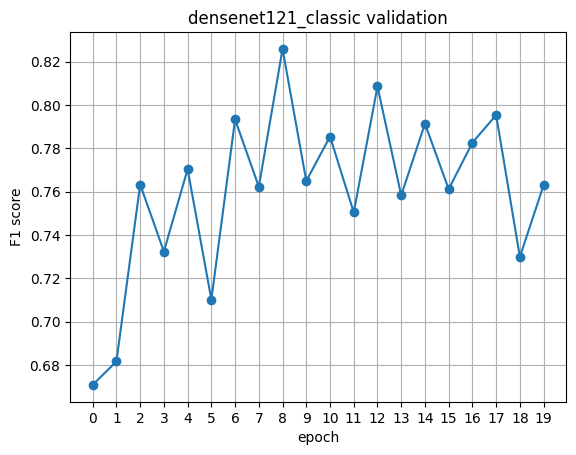

In [19]:
run_experiment(densenet121_classic)

Epoch 0: Train time 12.47 s, Validation time 1.66 s, Validation F1 0.65
Epoch 1: Train time 12.95 s, Validation time 1.65 s, Validation F1 0.82
Epoch 2: Train time 12.38 s, Validation time 1.64 s, Validation F1 0.80
Epoch 3: Train time 12.43 s, Validation time 1.64 s, Validation F1 0.77
Epoch 4: Train time 12.30 s, Validation time 1.60 s, Validation F1 0.79
Epoch 5: Train time 13.28 s, Validation time 1.72 s, Validation F1 0.75
Epoch 6: Train time 12.30 s, Validation time 1.64 s, Validation F1 0.83
Epoch 7: Train time 12.53 s, Validation time 1.70 s, Validation F1 0.79
Epoch 8: Train time 12.35 s, Validation time 1.59 s, Validation F1 0.86
Epoch 9: Train time 12.52 s, Validation time 1.66 s, Validation F1 0.81
Epoch 10: Train time 12.65 s, Validation time 1.64 s, Validation F1 0.79
Epoch 11: Train time 12.27 s, Validation time 1.69 s, Validation F1 0.84
Epoch 12: Train time 12.45 s, Validation time 1.67 s, Validation F1 0.85
Epoch 13: Train time 12.27 s, Validation time 1.67 s, Validat

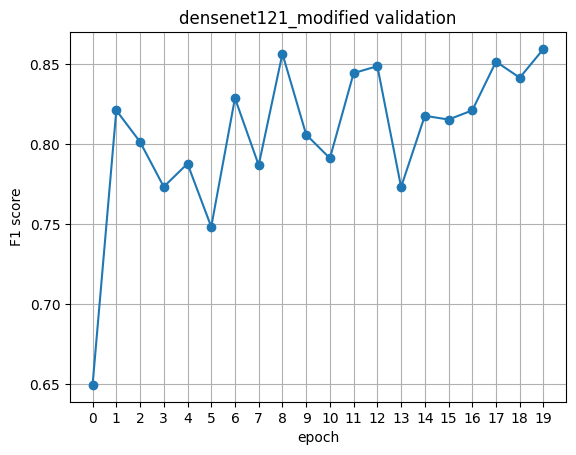

In [20]:
run_experiment(densenet121_modified)

## Вывод результатов

На диаграмме ниже представлены значения Macro F1 score на тестовой выборке для моделей, выбранных в каждом из экспериментов.

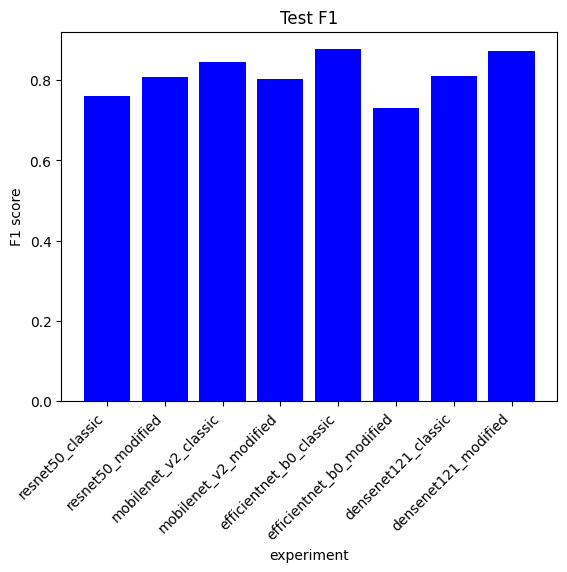

In [21]:
model_names = [*test_f1_stat.keys()]
f1_scores = [*test_f1_stat.values()]
plt.bar(model_names, f1_scores, color="blue")
plt.xlabel("experiment")
plt.ylabel("F1 score")
plt.title("Test F1")
plt.xticks(rotation=45, ha="right")
plt.show()